In [ ]:
import numpy as np
from typing import Union


def Round(number: float, precision: int = 4) -> float:
    factor = 10 ** precision
    return round(float(number) * factor) / factor

def MakeVectors(*args) -> np.ndarray:
    return np.array(object=args)

def DotProduct(matrix: np.ndarray, vector: np.ndarray) -> np.ndarray:
    return np.dot(matrix, vector)

# =============================================================================

def TransitionMatrix(matrix: list) -> np.ndarray:
    return MakeVectors(*matrix)

def PeopleVector(people_industry: int, people_academia: int) -> np.ndarray:
    return MakeVectors(people_industry, people_academia)

# =============================================================================

def CalculatePeopleDistribution(percent: float, total_people: int) -> int:
    return percent * total_people, (1 - percent) * total_people

def CalculatePeopleInitialState(
    total_people: int, percentage_industry: float = None,  percentage_academia: float = None, 
) -> np.ndarray:

    if percentage_industry is not None:
        people_industry, people_academia = CalculatePeopleDistribution(percentage_industry, total_people)
        return PeopleVector(people_industry, people_academia)

    elif percentage_academia is not None:
        people_academia, people_industry = CalculatePeopleDistribution(percentage_academia, total_people)
        return PeopleVector(people_industry, people_academia)
    
    else:
        raise ValueError("Either percentage_industry or percentage_academia must be provided.")

def CalculatePeopleNextYear(transition_matrix: np.ndarray, people: np.ndarray) -> np.ndarray:
    return DotProduct(transition_matrix, people)

# =============================================================================

def UnpackData(history: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X_axis = history[:, 0]
    Y_axis_industry = history[:, 1]
    Y_axis_academia = history[:, 2]
    return X_axis, Y_axis_industry, Y_axis_academia

# =============================================================================

def FindChangeYears(people_history: list[tuple[int, np.ndarray]]) -> list[int]:
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    leader_array = np.sign(Y_axis_industry - Y_axis_academia)
    change_indices = np.where(leader_array[:-1] != leader_array[1:])[0]
    change_years = X_axis[change_indices + 1]
    return change_years.tolist()

# =============================================================================

def GetDataAs(
    percentage_industry: float, total_people: int, year: int,
    people_industry: float, people_academia: float,
    as_float: bool = True, precision: int = 4,
) -> Union[list[float], np.ndarray]:
    if as_float:
        return [
            Round(percentage_industry, precision), Round(total_people, precision), year,
            Round(people_industry, precision), Round(people_academia, precision),
        ]
    else:
        return np.array([
            percentage_industry, total_people, year, 
            people_industry, people_academia,
        ], dtype=float)

def SimulateYears(
    initial_year: int, period_of_time: int,
    people: np.ndarray, transition_matrix: np.ndarray, 
    total_people: int, percentage_industry: float,
    step: int = 1, response_as_float: bool = True, response_precision: int = 4,
) -> np.ndarray:

    history = []
    
    start = initial_year
    stop = initial_year + period_of_time
    
    # Vector Structure: [percentage_industry, total_people, year, people_industry, people_academia]
    history.append(GetDataAs(percentage_industry, total_people, start, people[0], people[1], as_float=response_as_float, precision=response_precision))
    
    for year in range(start + 1, stop + 1, step):
        people = CalculatePeopleNextYear(transition_matrix, people)
        history.append(GetDataAs(percentage_industry, total_people, year, people[0], people[1], as_float=response_as_float, precision=response_precision))

    return np.array(history, dtype=object)

def Simulation(
    total_people: int,
    initial_year: int,
    period_of_time: int,
    transition_matrix: np.ndarray,
    percentage_people_industry: float,

    qnt_sample_total_people: int = 5,
    step_sample_total_people: int = 10_000,

    qnt_sample_percentage_people_industry: int = 5,
    step_sample_percentage_people_industry: float = 0.1,
) -> list[np.ndarray]:
    
    all_results = []

    for i in range(qnt_sample_total_people):
        total_people_i = total_people + i * step_sample_total_people

        for j in range(qnt_sample_percentage_people_industry):
            percentage_people_industry_j = percentage_people_industry + j * step_sample_percentage_people_industry
            
            people = CalculatePeopleInitialState(
                total_people=total_people_i, 
                percentage_industry=percentage_people_industry_j,
            )

            peopleHistory = SimulateYears(
                people=people,
                initial_year=initial_year,
                period_of_time=period_of_time,
                transition_matrix=transition_matrix,
                
                total_people=total_people_i, # Pass total_people here
                percentage_industry=percentage_people_industry_j, # Pass percentage here
            )

            all_results.append(peopleHistory)

    return all_results


In [60]:
def GetTicks(initial_value: float, final_value: float, num_ticks: int = 21, dtype: object = int) -> np.ndarray:
    return np.linspace(initial_value, final_value, num_ticks, dtype=dtype)

def GetMinMaxValues(*args: list[float], delta_up: float = 1.1, delta_down: float = 0.8) -> tuple[float, float]:
    return min(min(arg) for arg in args) * delta_down, max(max(arg) for arg in args) * delta_up

def GetGraphicParameters(
    people_history: list[tuple[int, np.ndarray]],
    initial_year: int, period_of_time: int,
) -> dict[str, object]:
    
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    Y_min, Y_max = GetMinMaxValues(Y_axis_industry, Y_axis_academia)
    
    return X_axis, Y_axis_industry, Y_axis_academia, {
        'Y_min': Y_min, 'Y_max': Y_max,
        'X_ticks': GetTicks(initial_value = initial_year, final_value = initial_year + period_of_time), 
        'Y_ticks': GetTicks(initial_value=Y_min, final_value=Y_max, dtype=float), 
    }

def GetMax(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return max(Array)

def GetMin(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return min(Array)

def GetMaxFromDict(data: dict[int, np.ndarray]) -> float:
    all_max = [GetMax(v) for v in data.values()]
    return max(all_max)

def GetMinFromDict(data: dict[int, np.ndarray]) -> float:
    all_min = [GetMin(v) for v in data.values()]
    return min(all_min)

def GetGlobalMaxAndMin(Responses: list[np.ndarray]) -> tuple[float, float]:
    AllMaximus, AllMinimus = [], []

    for response in Responses:
        u, v = response[:, -2], response[:, -1]
        AllMaximus.append(max(GetMax(u), GetMax(v)))
        AllMinimus.append(min(GetMin(u), GetMin(v)))

    return max(AllMaximus), min(AllMinimus), AllMaximus, AllMinimus


In [61]:
T = [
    [0.99, 0.2], 
    [0.01, 0.8],
]

transitionMatrix = TransitionMatrix(matrix=T)


In [62]:
totalPeople = 10_000
percentagePeopleIndustry = 0.1

initialYear = 2025
periodOfTime = 20
finalYear = initialYear + periodOfTime

qntSampleTotalPeople = 8
stepSampleTotalPeople = 10_000

qntSamplePercentagePeopleIndustry = 2
stepSamplePercentagePeopleIndustry = 0.8



In [63]:
Responses = Simulation(
    
    # Given parameters:
    total_people = totalPeople,
    initial_year = initialYear,
    period_of_time = periodOfTime,
    transition_matrix = transitionMatrix,
    percentage_people_industry = percentagePeopleIndustry,

    # Sampling parameters:
    
    # 1. Vary total people:
    qnt_sample_total_people = qntSampleTotalPeople,
    step_sample_total_people = stepSampleTotalPeople,
    
    # 2. Vary initial percentage of people in industry:
    qnt_sample_percentage_people_industry=qntSamplePercentagePeopleIndustry,
    step_sample_percentage_people_industry=stepSamplePercentagePeopleIndustry,
)

GlobalMaximus, GlobalMinimus, AllMaximus, AllMinimus = GetGlobalMaxAndMin(Responses)


In [64]:
import matplotlib.pyplot as plt

def PlotByFixedPercentage(
        responses: list[np.ndarray], 
        percentage_index: int,
        Maximus: float,
    ) -> None:
    plt.figure(figsize=(14, 8))

    # Flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0) 
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_flat[:, 0])[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_flat[data_flat[:, 0] == target_percentage]
    
    # Get unique total people counts and create a color map
    total_people_counts = np.unique(data_at_percentage[:, 1])
    colors = plt.cm.jet(np.linspace(0, 1, len(total_people_counts)))

    # Plot each simulation run with a unique color
    for i, total_people in enumerate(total_people_counts):
        
        # Filter data for the current total people count
        current_data = data_at_percentage[data_at_percentage[:, 1] == total_people]

        # Unpack the data
        years = current_data[:, 2]
        industry = current_data[:, 3]
        academia = current_data[:, 4]

        # Plot Industry and Academia on the same axes with the same color
        plt.plot(years, industry, color=colors[i], linestyle='-', label=f'Industry ({total_people:.0f} total)')
        plt.plot(years, academia, color=colors[i], linestyle='--')

    # Set Y-axis from 0 to Maximus with padding
    Y_max_padded = Maximus * 1.05  # Add 5% padding at the top
    Y_ticks = GetTicks(initial_value=0, final_value=Y_max_padded, dtype=float)
    
    # Set X-axis ticks
    X_ticks = GetTicks(initial_value=years[0], final_value=years[-1])
    
    plt.ylim(0, Y_max_padded); plt.yticks(Y_ticks)
    plt.xlim(years[0], years[-1]); plt.xticks(X_ticks, rotation=45)
    
    plt.title(f'People in Industry vs Academia Over Time\n(Initial Percentage of Researches in Industry Fixed at {target_percentage:.0%})')
    plt.xlabel('Years'); plt.ylabel('Number of People')
    plt.legend(); plt.grid(alpha=0.3); plt.show()


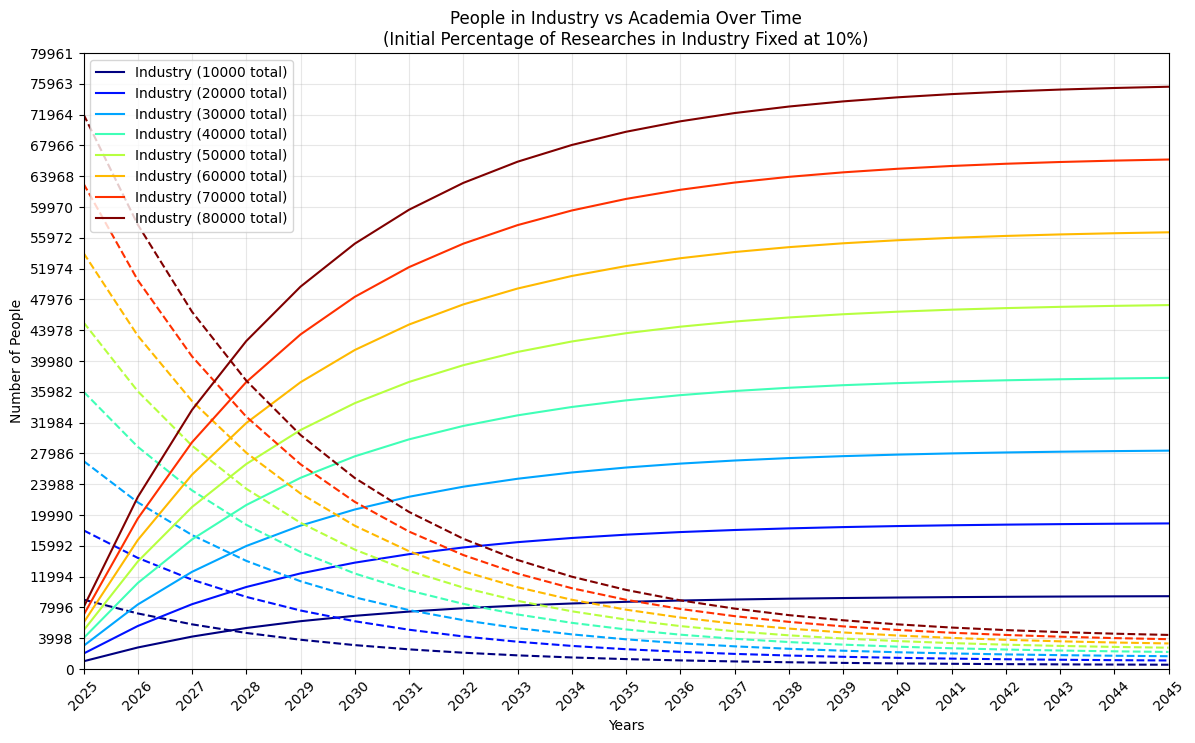

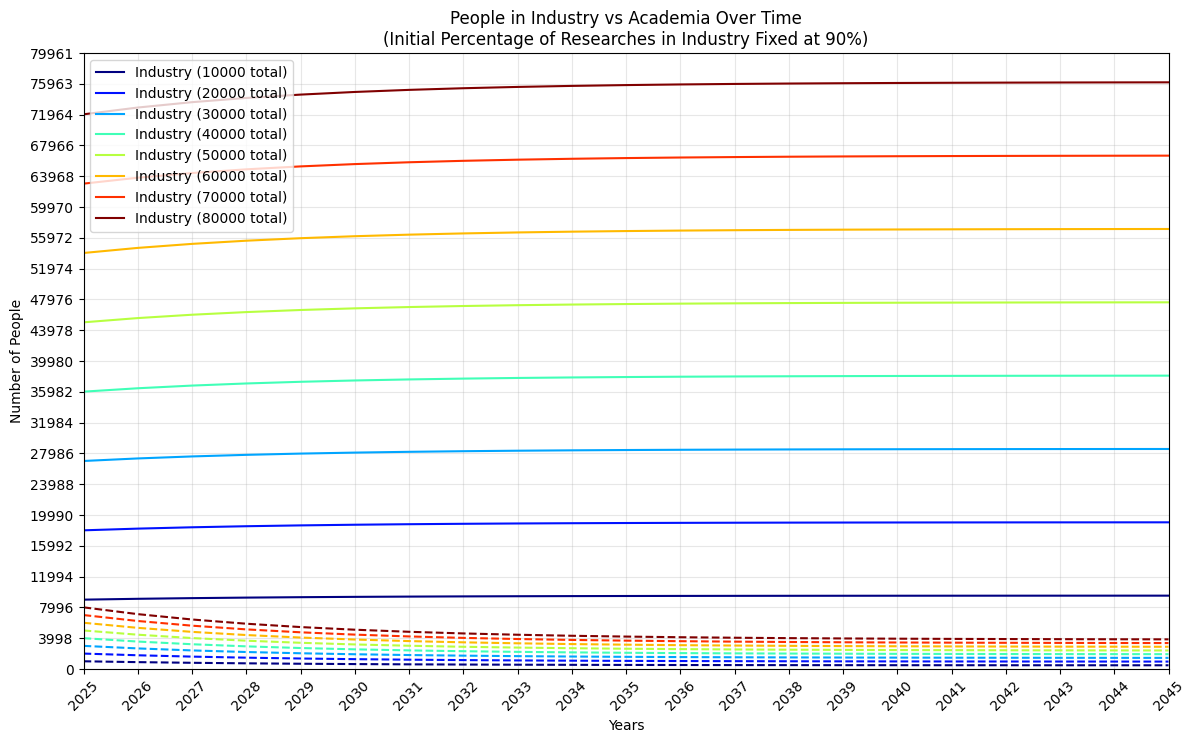

In [65]:
for simulation_people_by_percentage in range(qntSamplePercentagePeopleIndustry):
    PlotByFixedPercentage(
        responses=Responses, 
        Maximus=GlobalMaximus,
        percentage_index=simulation_people_by_percentage, 
    )


## `Testing`:

In [66]:
percentage_index = 1

In [36]:
data_flat = np.concatenate(Responses, axis=0) 
data_flat

array([[0.1, 10000.0, 2025, 1000.0, 9000.0],
       [0.1, 10000.0, 2026, 2790.0, 7210.0],
       [0.1, 10000.0, 2027, 4204.1, 5795.9],
       ...,
       [0.9, 80000.0, 2043, 76130.2825, 3869.7175],
       [0.9, 80000.0, 2044, 76142.9232, 3857.0768],
       [0.9, 80000.0, 2045, 76152.9093, 3847.0907]],
      shape=(336, 5), dtype=object)

In [37]:
target_percentage = np.unique(data_flat[:, 0].astype(float))[percentage_index]
target_percentage


np.float64(0.9)

In [38]:
data_at_percentage = data_flat[data_flat[:, 0].astype(float) == target_percentage]
data_at_percentage


array([[0.9, 10000.0, 2025, 9000.0, 1000.0],
       [0.9, 10000.0, 2026, 9110.0, 890.0],
       [0.9, 10000.0, 2027, 9196.9, 803.1],
       [0.9, 10000.0, 2028, 9265.551, 734.449],
       [0.9, 10000.0, 2029, 9319.7853, 680.2147],
       [0.9, 10000.0, 2030, 9362.6304, 637.3696],
       [0.9, 10000.0, 2031, 9396.478, 603.522],
       [0.9, 10000.0, 2032, 9423.2176, 576.7824],
       [0.9, 10000.0, 2033, 9444.3419, 555.6581],
       [0.9, 10000.0, 2034, 9461.0301, 538.9699],
       [0.9, 10000.0, 2035, 9474.2138, 525.7862],
       [0.9, 10000.0, 2036, 9484.6289, 515.3711],
       [0.9, 10000.0, 2037, 9492.8568, 507.1432],
       [0.9, 10000.0, 2038, 9499.3569, 500.6431],
       [0.9, 10000.0, 2039, 9504.4919, 495.5081],
       [0.9, 10000.0, 2040, 9508.5486, 491.4514],
       [0.9, 10000.0, 2041, 9511.7534, 488.2466],
       [0.9, 10000.0, 2042, 9514.2852, 485.7148],
       [0.9, 10000.0, 2043, 9516.2853, 483.7147],
       [0.9, 10000.0, 2044, 9517.8654, 482.1346],
       [0.9, 10000.0,

In [39]:
total_people_counts = np.unique(data_at_percentage[:, 1].astype(float))
total_people_counts


array([10000., 20000., 30000., 40000., 50000., 60000., 70000., 80000.])

In [40]:
colors = plt.cm.jet(np.linspace(0, 1, len(total_people_counts)))
colors


array([[0.        , 0.        , 0.5       , 1.        ],
       [0.        , 0.06470588, 1.        , 1.        ],
       [0.        , 0.64509804, 1.        , 1.        ],
       [0.24984187, 1.        , 0.71790006, 1.        ],
       [0.71790006, 1.        , 0.24984187, 1.        ],
       [1.        , 0.72694263, 0.        , 1.        ],
       [1.        , 0.18954248, 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 1.        ]])

In [41]:
total_people_counts

array([10000., 20000., 30000., 40000., 50000., 60000., 70000., 80000.])

In [42]:
idx = 1

total_people = total_people_counts[idx]
current_data = data_at_percentage[data_at_percentage[:, 1].astype(float) == total_people]

years = current_data[:, 2].astype(float)
industry = current_data[:, 3].astype(float)
academia = current_data[:, 4].astype(float)

# Calculate the ratio and handle division by zero
ratio = academia / industry
ratio = np.nan_to_num(ratio, nan=0, posinf=0) # Replace inf with 0, as it happens at year 0

total_people, current_data, ratio


(np.float64(20000.0),
 array([[0.9, 20000.0, 2025, 18000.0, 2000.0],
        [0.9, 20000.0, 2026, 18220.0, 1780.0],
        [0.9, 20000.0, 2027, 18393.8, 1606.2],
        [0.9, 20000.0, 2028, 18531.102, 1468.898],
        [0.9, 20000.0, 2029, 18639.5706, 1360.4294],
        [0.9, 20000.0, 2030, 18725.2608, 1274.7392],
        [0.9, 20000.0, 2031, 18792.956, 1207.044],
        [0.9, 20000.0, 2032, 18846.4352, 1153.5648],
        [0.9, 20000.0, 2033, 18888.6838, 1111.3162],
        [0.9, 20000.0, 2034, 18922.0602, 1077.9398],
        [0.9, 20000.0, 2035, 18948.4276, 1051.5724],
        [0.9, 20000.0, 2036, 18969.2578, 1030.7422],
        [0.9, 20000.0, 2037, 18985.7137, 1014.2863],
        [0.9, 20000.0, 2038, 18998.7138, 1001.2862],
        [0.9, 20000.0, 2039, 19008.9839, 991.0161],
        [0.9, 20000.0, 2040, 19017.0973, 982.9027],
        [0.9, 20000.0, 2041, 19023.5068, 976.4932],
        [0.9, 20000.0, 2042, 19028.5704, 971.4296],
        [0.9, 20000.0, 2043, 19032.5706, 967.4294]

In [43]:
idx = 3

total_people = total_people_counts[idx]
current_data = data_at_percentage[data_at_percentage[:, 1].astype(float) == total_people]

years = current_data[:, 2].astype(float)
industry = current_data[:, 3].astype(float)
academia = current_data[:, 4].astype(float)

# Calculate the ratio and handle division by zero
ratio = academia / industry
ratio = np.nan_to_num(ratio, nan=0, posinf=0) # Replace inf with 0, as it happens at year 0

total_people, current_data, ratio


(np.float64(40000.0),
 array([[0.9, 40000.0, 2025, 36000.0, 4000.0],
        [0.9, 40000.0, 2026, 36440.0, 3560.0],
        [0.9, 40000.0, 2027, 36787.6, 3212.4],
        [0.9, 40000.0, 2028, 37062.204, 2937.796],
        [0.9, 40000.0, 2029, 37279.1412, 2720.8588],
        [0.9, 40000.0, 2030, 37450.5215, 2549.4785],
        [0.9, 40000.0, 2031, 37585.912, 2414.088],
        [0.9, 40000.0, 2032, 37692.8705, 2307.1295],
        [0.9, 40000.0, 2033, 37777.3677, 2222.6323],
        [0.9, 40000.0, 2034, 37844.1205, 2155.8795],
        [0.9, 40000.0, 2035, 37896.8552, 2103.1448],
        [0.9, 40000.0, 2036, 37938.5156, 2061.4844],
        [0.9, 40000.0, 2037, 37971.4273, 2028.5727],
        [0.9, 40000.0, 2038, 37997.4276, 2002.5724],
        [0.9, 40000.0, 2039, 38017.9678, 1982.0322],
        [0.9, 40000.0, 2040, 38034.1945, 1965.8055],
        [0.9, 40000.0, 2041, 38047.0137, 1952.9863],
        [0.9, 40000.0, 2042, 38057.1408, 1942.8592],
        [0.9, 40000.0, 2043, 38065.1412, 1934.

In [71]:

def CalculateRatioPerTotalPeople(
        responses: list[np.ndarray], 
        percentage_index: int,
    ) -> dict[int, np.ndarray]:

    data_flat = np.concatenate(responses, axis=0)

    target_percentage = np.unique(data_flat[:, 0].astype(float))[percentage_index]
    data_at_percentage = data_flat[data_flat[:, 0].astype(float) == target_percentage]

    total_people_counts = np.unique(data_at_percentage[:, 1].astype(float))

    ratios_per_total_people = {}
    for total_people in total_people_counts:

        current_data = data_at_percentage[data_at_percentage[:, 1].astype(float) == total_people]
        
        years = current_data[:, 2].astype(float)
        industry = current_data[:, 3].astype(float)
        academia = current_data[:, 4].astype(float)

        ratio = academia / industry
        ratio = np.nan_to_num(ratio, nan=0, posinf=0)

        ratios_per_total_people[int(total_people)] = ratio

    return ratios_per_total_people

percentage_index = 1
ratios_dict = CalculateRatioPerTotalPeople(Responses, percentage_index)
ratios_dict



{10000: array([0.11111111, 0.09769484, 0.0873229 , 0.07926663, 0.07298609,
        0.06807591, 0.06422853, 0.06120865, 0.05883503, 0.05696736,
        0.05549655, 0.05433751, 0.05342366, 0.05270284, 0.0521341 ,
        0.05168522, 0.05133087, 0.05105111, 0.0508302 , 0.05065575,
        0.05051797]),
 20000: array([0.11111111, 0.09769484, 0.0873229 , 0.07926663, 0.07298609,
        0.06807591, 0.06422853, 0.06120865, 0.05883503, 0.05696736,
        0.05549655, 0.05433751, 0.05342366, 0.05270284, 0.05213409,
        0.05168521, 0.05133087, 0.05105111, 0.0508302 , 0.05065575,
        0.05051798]),
 30000: array([0.11111111, 0.09769484, 0.0873229 , 0.07926663, 0.07298609,
        0.06807592, 0.06422853, 0.06120864, 0.05883502, 0.05696736,
        0.05549655, 0.05433751, 0.05342366, 0.05270284, 0.05213409,
        0.05168521, 0.05133087, 0.05105111, 0.0508302 , 0.05065575,
        0.05051797]),
 40000: array([0.11111111, 0.09769484, 0.0873229 , 0.07926663, 0.07298609,
        0.06807591, 0.

In [72]:
MaxDict, MinDict = GetMaxFromDict(ratios_dict), GetMinFromDict(ratios_dict)
MaxDict, MinDict


(np.float64(0.1111111111111111), np.float64(0.05051796996604842))

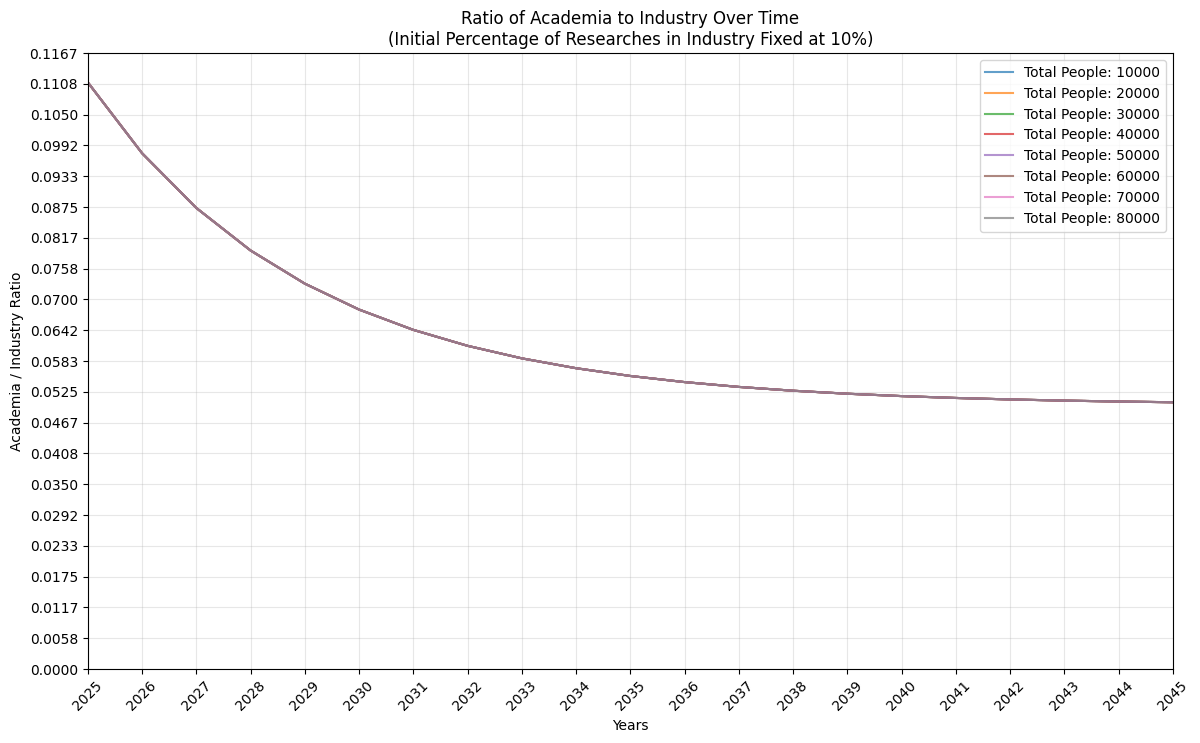

In [73]:
plt.figure(figsize=(14, 8))

for total_people, ratio in ratios_dict.items():
    plt.plot(years, ratio, linestyle='-', label=f'Total People: {total_people}', alpha=0.7)

Y_max_padded = MaxDict * 1.05

Y_ticks = GetTicks(initial_value=0, final_value=Y_max_padded, dtype=float)
X_ticks = GetTicks(initial_value=years[0], final_value=years[-1])

plt.ylim(0, Y_max_padded); plt.yticks(Y_ticks)
plt.xlim(years[0], years[-1]); plt.xticks(X_ticks, rotation=45)

plt.title(f'Ratio of Academia to Industry Over Time\n(Initial Percentage of Researches in Industry Fixed at {target_percentage:.0%})')
plt.xlabel('Years'); plt.ylabel('Academia / Industry Ratio')

plt.legend(); plt.grid(alpha=0.3); plt.show()
